# A Data Science Example In Julia Using Education Statistics From The Work Bank
By Clarman Cruz

February 2020

## Introduction
Queryverse along other Julia packages are great for a data science project. We are able to efficiently load data stored in many different file formats. Clean the data and prepare it for analysis using the Query package. Improve data quality with the easiness of the Query package along other Julia packages. Then, we graph all our data with just a single DataVoyager command. We can quickly store both our data files and graphs in a couple of file formats. Depending on the type of data, we can just continue with Julia machine learning packages to perform predictions. 

This JupyterLab is meant as a tutorial. It showcases [Queryverse](https://www.queryverse.org), 
[ARCHModels](https://s-broda.github.io/ARCHModels.jl/stable/) package, and some basic [Julia](https://julialang.org) programming. It is an end to end example using a real-world dataset from The World Bank website. We start the journey reading the statistics files, and then cleaning the data. We prepare further the data for deeper analysis. Afterwards, we graph the prepared data and create an interactive data visualizer. Then, we save our prepared data and graphs for publication, or team sharing. Lastly, we predict future time series values with a machine learning model created with the ARCHModels package.

## Reading In The Education Statitics Files
Queryverse supports reading from different file formats including:
* CSVFiles.jl can read and write CSV files. Under the hood it uses the extremly fast TextParse.jl package.
* FeatherFiles.jl can read and write Feather files.
* ExcelFiles.jl can read and write Excel Files.
* StatFiles.jl can read SPSS, STATA and SAS files.
* ParquetFiles.jl can read Parquet files.
Just ensure the file name contains for correct format extension.  For example, CSV file names end with .csv while feather names files end with .feather.  Queryverse uses the file extension to determine the file format. 

Our data set is composed of 5 CSV files obtained from the The World Bank data catalog, https://datacatalog.worldbank.org/dataset/education-statistics.  The data set is statistics about education around the world.  The data "covers over 4,000 internationally comparable indicators that describe education access, progression, completion, literacy, teachers, population, and expenditures. The indicators cover the education cycle from pre-primary to vocational and tertiary education."

* EdStatsCountry.csv is static data such as ISO Country Code, Country Long Name, Region, Income Group, and External debt Reporting status
* EdStatsCountry-Series.csv is a map between one Country Code and its Series Codes
* EdStatsData.csv is the main file in the data set contain Country Code, Indicator values from 1970 to 2100.  "Adjusted net enrolment rate, lower secondary, both sexes (%)", "Adjusted net enrolment rate, primary, female (%)", "Adjusted net enrolment rate, primary, gender parity index (GPI)", and "Annual statutory teacher salaries in public institutions in USD" are examples of Indicators.  The indicator values after the last reported measurement are estimates, if found.
* EdStatsFootNote.csv is static data of Country Code, Series Code, Year, and Description
* EdStatsSeries.csv is static data of Series Code, Topic, Indicator Name, Long definition, Unit of measure, Periodicity, and Statistical concept and methodology.  The indicators are time series


In [2]:
using Queryverse, IndexedTables, DataFrames, FeatherFiles, ARCHModels
cd("C:\\Users\\drcxcruz\\Documents\\TheWorkBank\\EdStats")

In [3]:
fileName = "EdStatsCountry.csv"
dfCountry = load(fileName) |> DataFrame;  # the ; indicates not the read from disk into Julia the entire file
newColNames = [replace(String(n), " " => "_") for n in names(dfCountry)] # remove spaces in the column names
itCountry = load(fileName, colnames = newColNames) 
table(itCountry, pkey = [:Country_Code])

Table with 241 rows, 32 columns:
Columns:
#   colname                                            type
──────────────────────────────────────────────────────────────
1   Country_Code                                       String
2   Short_Name                                         String
3   Table_Name                                         String
4   Long_Name                                          String
5   2-alpha_code                                       String
6   Currency_Unit                                      String
7   Special_Notes                                      String
8   Region                                             String
9   Income_Group                                       String
10  WB-2_code                                          String
11  National_accounts_base_year                        String
12  National_accounts_reference_year                   String
13  SNA_price_valuation                                String
14  Lending_category         

In [3]:
fileName = "EdStatsCountry-Series.csv"
itCountrySeries = load(fileName, colnames = ["Country_Code", "Series_Code", "Description"]) 
table(itCountrySeries, pkey = [:Country_Code, :Series_Code])

Table with 613 rows, 4 columns:
Columns:
#  colname       type
────────────────────────
1  Country_Code  String
2  Series_Code   String
3  Description   String
4                Missing

In [4]:
fileName = "EdStatsData.csv"  
colNames = ["Country_Name", "Country_Code", "Indicator_Name", "Indicator_Code"]
years = [string(y) for y in 1970:2100]
append!(colNames, years)

# reading from Turkey to Zimbabwe including United Kingdom and United States
itData = load(fileName, colnames = colNames, skiplines_begin = 817297, header_exists=false); 
table(itData, pkey = [:Country_Code, :Indicator_Code])

Table with 69634 rows, 70 columns:
Columns:
#   colname         type
───────────────────────────
1   Country_Name    String
2   Country_Code    String
3   Indicator_Name  String
4   Indicator_Code  String
5   1970            String
6   1971            String
7   1972            String
8   1973            String
9   1974            String
10  1975            String
11  1976            String
12  1977            String
13  1978            String
14  1979            String
15  1980            String
16  1981            String
17  1982            String
18  1983            String
19  1984            String
20  1985            String
21  1986            String
22  1987            String
23  1988            String
24  1989            String
25  1990            String
26  1991            String
27  1992            String
28  1993            String
29  1994            String
30  1995            String
31  1996            String
32  1997            String
33  1998            String
34  1999    

In [5]:
fileName = "EdStatsFootNote.csv"
itFootNote = load(fileName, colnames = ["Country_Code", "Series_Code", "Year", "Description"]) 
table(itFootNote, pkey = [:Country_Code, :Series_Code])

Table with 643638 rows, 5 columns:
Columns:
#  colname       type
────────────────────────
1  Country_Code  String
2  Series_Code   String
3  Year          String
4  Description   String
5                Missing

In [6]:
fileName ="EdStatsSeries.csv"
dfSeries = load(fileName) |> DataFrame;
newColNames = [replace(String(n), " " => "_") for n in names(dfSeries)]  # remove spaces from the column names
itSeries = load(fileName, colnames = newColNames) 
table(itSeries, pkey = [:Series_Code])

Table with 3665 rows, 21 columns:
Columns:
#   colname                              type
────────────────────────────────────────────────
1   Series_Code                          String
2   Topic                                String
3   Indicator_Name                       String
4   Short_definition                     String
5   Long_definition                      String
6   Unit_of_measure                      String
7   Periodicity                          String
8   Base_Period                          String
9   Other_notes                          String
10  Aggregation_method                   String
11  Limitations_and_exceptions           String
12  Notes_from_original_source           String
13  General_comments                     String
14  Source                               String
15  Statistical_concept_and_methodology  String
16  Development_relevance                String
17  Related_source_links                 String
18  Other_web_links                      Strin

Let's see a few charactericts of our data by joining a couple of files. 


In [7]:
query = @from c in itCountry begin
    @join s in itCountrySeries on c.Country_Code equals s.Country_Code
    @select {c.Country_Code, c.Region, c.Long_Name, c.Income_Group, c.Lending_category, c.Government_Accounting_concept, s.Series_Code, s.Description}
    end
table(query, pkey = [:Country_Code])

query |> @filter( occursin(r"ZWE|VIR|URY|USA|GBR|TUR|ARE", _.Country_Code)) |> @orderby(_.Region) |> @thenby(_.Long_Name)

Country_Code,Region,Long_Name,Income_Group,Lending_category,Government_Accounting_concept,Series_Code,Description
"""TUR""","""Europe & Central Asia""","""Republic of Turkey""","""Upper middle income""","""IBRD""","""Consolidated central government""","""SP.POP.TOTL""","""Data sources : United Nations World Population Prospects"""
"""TUR""","""Europe & Central Asia""","""Republic of Turkey""","""Upper middle income""","""IBRD""","""Consolidated central government""","""SP.POP.GROW""","""Data sources : United Nations World Population Prospects"""
"""GBR""","""Europe & Central Asia""","""United Kingdom of Great Britain and Northern Ireland""","""High income: OECD""","""""","""Consolidated central government""","""SP.POP.GROW""","""Data sources: Eurostat"""
"""GBR""","""Europe & Central Asia""","""United Kingdom of Great Britain and Northern Ireland""","""High income: OECD""","""""","""Consolidated central government""","""SP.POP.TOTL""","""Data sources : Eurostat"""
"""URY""","""Latin America & Caribbean""","""Oriental Republic of Uruguay""","""High income: nonOECD""","""IBRD""","""Consolidated central government""","""SP.POP.GROW""","""Data sources: United Nations World Population Prospects"""
"""URY""","""Latin America & Caribbean""","""Oriental Republic of Uruguay""","""High income: nonOECD""","""IBRD""","""Consolidated central government""","""SP.POP.TOTL""","""Data sources : United Nations World Population Prospects"""
"""VIR""","""Latin America & Caribbean""","""Virgin Islands of the United States""","""High income: nonOECD""","""""","""""","""SP.POP.TOTL""","""Data sources : U.S. Census Bureau, United Nations Population and Vital Statistics Report"""
"""VIR""","""Latin America & Caribbean""","""Virgin Islands of the United States""","""High income: nonOECD""","""""","""""","""SP.POP.GROW""","""Data sources: U.S. Census Bureau, United Nations Population and Vital Statistics Report"""
"""ARE""","""Middle East & North Africa""","""United Arab Emirates""","""High income: nonOECD""","""""","""Consolidated central government""","""SP.POP.GROW""","""Data sources: United Nations World Population Prospects"""
"""ARE""","""Middle East & North Africa""","""United Arab Emirates""","""High income: nonOECD""","""""","""Consolidated central government""","""SP.POP.TOTL""","""Data sources : United Nations World Population Prospects"""


## Data Cleaning and Preparation
Let's analyze years from 1990 to 2014.  We are considering a few of the indicators and the few countries. Yet, you can easily include more countries, indicators or years as you wish.  Let's pick the following indicators and their codes.  

* "Pupil-teacher ratio in secondary education (headcount basis)", "SE.SEC.ENRL.TC.ZS"
* "Rate of out-of-school youth of upper secondary school age, both sexes (%)", "UIS.ROFST.3.CP"
* "Rate of out-of-school youth of upper secondary school age, female (%)", "UIS.ROFST.3.F.CP"
* "Rate of out-of-school youth of upper secondary school age, male (%)", "UIS.ROFST.3.M.CP"
* "Government expenditure in secondary institutions education as % of GDP (%)", "XGDP.23.FSGOV.FDINSTADM.FFD"

We are going to analyze the relationship between pupil-teacher ratio and out-of-school youth rate in secondary school.  


In [8]:
# this is where you modify the year range, indicator list, or country list
dfClean = itData |>  
    @filter( occursin(r"ZWE|VIR|URY|USA|GBR|TUR|ARE", _.Country_Code)) |>
    @filter( occursin(r"SE.SEC.ENRL.TC.ZS|UIS.ROFST.3.CP|UIS.ROFST.3.F.CP|UIS.ROFST.3.M.CP|XGDP.23.FSGOV.FDINSTADM.FFD", _.Indicator_Code)) |> 
    @select(1:4, 25:49) |>  
    DataFrame

dfClean |> @filter(_.Country_Code == "USA")

Country_Name,Country_Code,Indicator_Name,Indicator_Code,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
"""United States""","""USA""","""Government expenditure in secondary institutions education as % of GDP (%)""","""XGDP.23.FSGOV.FDINSTADM.FFD""","""""","""""","""""","""""","""""","""""","""""","""""","""1.73608994483948""","""1.72523999214172""","""1.7501300573349""","""1.88098001480103""","""1.90707004070282""","""2.03250002861023""","""1.94648003578186""","""1.82843005657196""","""1.92949998378754""","""1.92969000339508""","""1.96256005764008""","""1.97350001335144""","""1.91955995559692""","""1.87390005588531""","""1.76548004150391""","""""",""""""
"""United States""","""USA""","""Pupil-teacher ratio in secondary education (headcount basis)""","""SE.SEC.ENRL.TC.ZS""","""""","""""","""""","""15.5334100723267""","""15.6976499557495""","""15.4257001876831""","""15.4034900665283""","""""","""15.1882801055908""","""14.9240102767944""","""14.6057996749878""","""15.1627101898193""","""14.8834495544434""","""14.9155302047729""","""14.9754199981689""","""14.9440803527832""","""14.6182203292847""","""14.5639095306396""","""14.3765897750854""","""13.9601697921753""","""13.7594299316406""","""14.4905595779419""","""14.6637201309204""","""14.6957397460938""","""14.7868299484253"""
"""United States""","""USA""","""Rate of out-of-school youth of upper secondary school age, both sexes (%)""","""UIS.ROFST.3.CP""","""""","""""","""""","""""","""""","""""","""""","""""","""""","""""","""15.3355""","""14.20598""","""16.60763""","""11.95517""","""10.79784""","""8.91003""","""8.92473""","""7.24616""","""7.10633""","""6.92348""","""9.4071""","""9.25726""","""10.49112""","""10.03378""","""7.50121"""
"""United States""","""USA""","""Rate of out-of-school youth of upper secondary school age, female (%)""","""UIS.ROFST.3.F.CP""","""""","""""","""""","""""","""""","""""","""""","""""","""""","""""","""15.97203""","""13.04092""","""16.74537""","""11.60295""","""10.80064""","""6.2645""","""6.21013""","""6.17753""","""6.56122""","""5.58257""","""9.36999""","""7.95532""","""9.75025""","""9.24792""","""6.52425"""
"""United States""","""USA""","""Rate of out-of-school youth of upper secondary school age, male (%)""","""UIS.ROFST.3.M.CP""","""""","""""","""""","""""","""""","""""","""""","""""","""""","""""","""14.7336""","""15.3063""","""16.47762""","""12.28699""","""10.79521""","""11.38762""","""11.46333""","""8.24965""","""7.61971""","""8.18763""","""9.44207""","""10.48286""","""11.18935""","""10.77544""","""8.4247"""


A few things before we move forward.  Make the years column float and shorten the indicators name.  The code columns are removed also. The column names are also shortening while keeping readability.

In [9]:
#convert year columns from string to float 
dfCleanFloat = copy(dfClean)
for c in 5:ncol(dfCleanFloat)
  dfCleanFloat[!,c] = map(x -> (v = tryparse(Float64,x); v == nothing ? missing : v),  dfCleanFloat[!,c])
end

function indicatorRename(name::String)
    if name == "Government expenditure in secondary institutions education as % of GDP (%)"
        return string("GovernmentExpenditure")
    elseif name == "Pupil-teacher ratio in secondary education (headcount basis)"
        return string("PupilTeacherRatio") 
    elseif name == "Rate of out-of-school youth of upper secondary school age, both sexes (%)"
        return string("RateOutofSchoolBothSexes") 
    elseif name == "Rate of out-of-school youth of upper secondary school age, female (%)"
        return string("RateOutofSchoolFemale") 
    elseif name == "Rate of out-of-school youth of upper secondary school age, male (%)"
        return string("RateOutofSchoolMale")
    end     
end

dfCleanFloat |> @select(3) |> @unique(_.Indicator_Name)  #unique Indicator Names

dfCleanShort = dfCleanFloat |> 
    @mutate(Indicator_Name = indicatorRename(_.Indicator_Name)) |>
    @select(-:Country_Code, -:Indicator_Code) |> 
    @rename(:Country_Name => :Country, :Indicator_Name => :Series) |> 
    @orderby(:Country )  |>
    @thenby(:Series) |> DataFrame

dfCleanShort |> @filter(_.Country == "United States")

Country,Series,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
"""United States""","""GovernmentExpenditure""",#NA,#NA,#NA,#NA,#NA,#NA,#NA,#NA,1.73609,1.72524,1.75013,1.88098,1.90707,2.0325,1.94648,1.82843,1.9295,1.92969,1.96256,1.9735,1.91956,1.8739,1.76548,#NA,#NA
"""United States""","""PupilTeacherRatio""",#NA,#NA,#NA,15.5334,15.6976,15.4257,15.4035,#NA,15.1883,14.924,14.6058,15.1627,14.8834,14.9155,14.9754,14.9441,14.6182,14.5639,14.3766,13.9602,13.7594,14.4906,14.6637,14.6957,14.7868
"""United States""","""RateOutofSchoolBothSexes""",#NA,#NA,#NA,#NA,#NA,#NA,#NA,#NA,#NA,#NA,15.3355,14.206,16.6076,11.9552,10.7978,8.91003,8.92473,7.24616,7.10633,6.92348,9.4071,9.25726,10.4911,10.0338,7.50121
"""United States""","""RateOutofSchoolFemale""",#NA,#NA,#NA,#NA,#NA,#NA,#NA,#NA,#NA,#NA,15.972,13.0409,16.7454,11.6029,10.8006,6.2645,6.21013,6.17753,6.56122,5.58257,9.36999,7.95532,9.75025,9.24792,6.52425
"""United States""","""RateOutofSchoolMale""",#NA,#NA,#NA,#NA,#NA,#NA,#NA,#NA,#NA,#NA,14.7336,15.3063,16.4776,12.287,10.7952,11.3876,11.4633,8.24965,7.61971,8.18763,9.44207,10.4829,11.1893,10.7754,8.4247


No data science project is complete without talking about missing values. Julia supports missing values as part of the language itself. The Julia document says that "missing values are represented via the missing object, which is the singleton instance of the type Missing. Missing is equivalent to NULL in SQL and NA in R and behaves like them in most situations."

Here for simplicity, we fill a missing value in a time series with the previous value. Take a look at the forwardBackwardFill function. First, the function fills missing values with a forward loop. Secondly, any values still missing are filled with a backward loop. A little recursion ensures we impute all values. In Python, such loops are slow. In Julia the loops are as fast as C. I implemented the function in C style to get the C speed point across.

In [10]:
function forwardBackwardFill(v)    
  if all(ismissing, v)
    # nothing we can do without any values    
    return v
  end
    
  nEnd = length(v)
  r = zeros(nEnd)
  r = convert(Vector{Union{Missing,Float64}}, r)  # to allow assinging a missing to a float array item 
  r[1] = v[1]   
       
  # forward filling
  for i in 2:nEnd
    if ismissing(v[i]) 
        r[i] = v[i-1]
    else
        r[i] = v[i]
    end
  end
  
  # backward filling
  for i in reverse(1:nEnd-1)
    if ismissing(r[i]) 
        r[i] = r[i+1]
    end
  end
    
  if any(ismissing, r) 
    forwardBackwardFill(r)     
  else 
    return r
  end
        
end

println(forwardBackwardFill([1,missing,missing,7]))
println(forwardBackwardFill([1,missing,4,missing,7]))
println(forwardBackwardFill([missing,missing,2]))
println(forwardBackwardFill([2,missing,missing,missing]))
println(forwardBackwardFill([missing,missing,missing,missing]))

Union{Missing, Float64}[1.0, 1.0, 7.0, 7.0]
Union{Missing, Float64}[1.0, 1.0, 4.0, 4.0, 7.0]
Union{Missing, Float64}[2.0, 2.0, 2.0]
Union{Missing, Float64}[2.0, 2.0, 2.0, 2.0]
Missing[missing, missing, missing, missing]


Next are a few helper functions. We imputate and rescale using the helper functions. We keep things simple for supportability. 

In [11]:
function getYearValues( df, r)
    v = convert(Vector, df[r,3:end])    #skipping country and series
    return v    
end

function setYearValues!( df, r, v)
    df[r,3:end] .= v 
end

function getMax( df, r)
   v = getYearValues( df, r)
   return partialsort(v,1,rev=true) 
end

function getMin( df, r)
   v = getYearValues( df, r)
   return partialsort(v,1,rev=false) 
end

function getFirst( df, r)
   v = getYearValues( df, r)
   return v[1] 
end

getFirst (generic function with 1 method)

In [12]:
dfImputation = copy(dfCleanShort)
for r in 1:nrow(dfImputation)
    v = getYearValues( dfImputation, r)
    fb = forwardBackwardFill(v)
    setYearValues!( dfImputation, r, fb)
end

dfImputation |> @filter(_.Country == "United States")

Country,Series,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
"""United States""","""GovernmentExpenditure""",1.73609,1.73609,1.73609,1.73609,1.73609,1.73609,1.73609,1.73609,1.73609,1.72524,1.75013,1.88098,1.90707,2.0325,1.94648,1.82843,1.9295,1.92969,1.96256,1.9735,1.91956,1.8739,1.76548,1.76548,1.76548
"""United States""","""PupilTeacherRatio""",15.5334,15.5334,15.5334,15.5334,15.6976,15.4257,15.4035,15.4035,15.1883,14.924,14.6058,15.1627,14.8834,14.9155,14.9754,14.9441,14.6182,14.5639,14.3766,13.9602,13.7594,14.4906,14.6637,14.6957,14.7868
"""United States""","""RateOutofSchoolBothSexes""",15.3355,15.3355,15.3355,15.3355,15.3355,15.3355,15.3355,15.3355,15.3355,15.3355,15.3355,14.206,16.6076,11.9552,10.7978,8.91003,8.92473,7.24616,7.10633,6.92348,9.4071,9.25726,10.4911,10.0338,7.50121
"""United States""","""RateOutofSchoolFemale""",15.972,15.972,15.972,15.972,15.972,15.972,15.972,15.972,15.972,15.972,15.972,13.0409,16.7454,11.6029,10.8006,6.2645,6.21013,6.17753,6.56122,5.58257,9.36999,7.95532,9.75025,9.24792,6.52425
"""United States""","""RateOutofSchoolMale""",14.7336,14.7336,14.7336,14.7336,14.7336,14.7336,14.7336,14.7336,14.7336,14.7336,14.7336,15.3063,16.4776,12.287,10.7952,11.3876,11.4633,8.24965,7.61971,8.18763,9.44207,10.4829,11.1893,10.7754,8.4247


We like to compare different kind of time series and between different countries.  Therefore, we must normalize the time series and start them at zero.  The result of normalization is to scale the original values to a range between 0 and 1.  We make each time series start at zero so we can compare their trend side by side.

Many machine learning models require the data to be standardized as well.  You can standardize the data yourself depending on your chosen machine learning model.  

In [13]:
dfNormalize = copy(dfImputation)
for r in 1:nrow(dfNormalize)
    v = getYearValues( dfNormalize, r)
    fMin = getMin(dfNormalize, r)
    fMax = getMax(dfNormalize, r)
    if ismissing(fMax - fMin)    
        n = Vector{Union{Missing, Float64}}(missing, length(v))
    elseif (fMax - fMin) == 0
        n = v
    else 
        n = (v .- fMin) ./ (fMax - fMin)
    end
    setYearValues!( dfNormalize, r, n)
end

dfNormalize |> @filter(_.Country == "United States")

Country,Series,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
"""United States""","""GovernmentExpenditure""",0.035312,0.035312,0.035312,0.035312,0.035312,0.035312,0.035312,0.035312,0.035312,0.0,0.0810065,0.506867,0.591779,1.0,0.720042,0.33584,0.664779,0.665397,0.772375,0.80798,0.632428,0.483825,0.130964,0.130964,0.130964
"""United States""","""PupilTeacherRatio""",0.915263,0.915263,0.915263,0.915263,1.0,0.859691,0.848232,0.848232,0.737197,0.60085,0.436674,0.724005,0.579924,0.596475,0.627375,0.611205,0.443082,0.415061,0.318416,0.103569,0.0,0.377217,0.466557,0.483077,0.530074
"""United States""","""RateOutofSchoolBothSexes""",0.868638,0.868638,0.868638,0.868638,0.868638,0.868638,0.868638,0.868638,0.868638,0.868638,0.868638,0.752002,1.0,0.51958,0.400072,0.205134,0.206652,0.0333204,0.0188814,0.0,0.256462,0.24099,0.3684,0.321174,0.0596573
"""United States""","""RateOutofSchoolFemale""",0.930722,0.930722,0.930722,0.930722,0.930722,0.930722,0.930722,0.930722,0.930722,0.930722,0.930722,0.668143,1.0,0.539325,0.467452,0.0610895,0.0562189,0.0532985,0.0876707,0.0,0.339289,0.212559,0.373354,0.328354,0.0843588
"""United States""","""RateOutofSchoolMale""",0.803112,0.803112,0.803112,0.803112,0.803112,0.803112,0.803112,0.803112,0.803112,0.803112,0.803112,0.867766,1.0,0.526905,0.358493,0.425372,0.43392,0.0711161,0.0,0.0641144,0.205733,0.323231,0.402989,0.356261,0.0908781


In [14]:
dfSeriesFromZero = copy(dfNormalize)
for r in 1:nrow(dfSeriesFromZero)
    v = getYearValues( dfSeriesFromZero, r)
    fFirst = getFirst(dfSeriesFromZero, r)
    n = v .- fFirst
    setYearValues!( dfSeriesFromZero, r, n)
end

dfSeriesFromZero |> @filter(_.Country == "United States")

Country,Series,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
"""United States""","""GovernmentExpenditure""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.035312,0.0456946,0.471555,0.556467,0.964688,0.68473,0.300528,0.629467,0.630085,0.737063,0.772668,0.597116,0.448513,0.0956522,0.0956522,0.0956522
"""United States""","""PupilTeacherRatio""",0.0,0.0,0.0,0.0,0.0847375,-0.0555715,-0.0670306,-0.0670306,-0.178065,-0.314412,-0.478589,-0.191258,-0.335339,-0.318787,-0.287888,-0.304057,-0.472181,-0.500201,-0.596847,-0.811693,-0.915263,-0.538045,-0.448705,-0.432185,-0.385189
"""United States""","""RateOutofSchoolBothSexes""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.116636,0.131362,-0.349058,-0.468566,-0.663504,-0.661986,-0.835318,-0.849757,-0.868638,-0.612176,-0.627648,-0.500238,-0.547464,-0.808981
"""United States""","""RateOutofSchoolFemale""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.262578,0.0692783,-0.391396,-0.46327,-0.869632,-0.874503,-0.877423,-0.843051,-0.930722,-0.591432,-0.718163,-0.557367,-0.602368,-0.846363
"""United States""","""RateOutofSchoolMale""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0646541,0.196888,-0.276206,-0.444618,-0.377739,-0.369192,-0.731995,-0.803112,-0.738997,-0.597379,-0.479881,-0.400123,-0.44685,-0.712233


We filled our missing years and normalized our data. Let's get ready to transform our data to time series style. The years are rows instead of columns. Our dataframe needs transposing. Luckily, Julia data frame package has the stack function to do so. The Julia Timeseries package requires the first column to be both unique and convertible to the time type. Our "timestamp" is the year only without any month or day. Thus, we cannot easily use the Julia Timeseries package.

In [15]:
dfStack = DataFrames.stack(dfSeriesFromZero, 3:ncol(dfSeriesFromZero)) 
dfTranspose = dfStack |> @rename(:variable => :Timestamp, :value => :Value) |> DataFrame

,Timestamp,Value,Country,Series
,Symbol,Float64⍰,String,String
1,1990,missing,Turkey,GovernmentExpenditure
2,1990,0.0,Turkey,PupilTeacherRatio
3,1990,0.0,Turkey,RateOutofSchoolBothSexes
4,1990,0.0,Turkey,RateOutofSchoolFemale
5,1990,0.0,Turkey,RateOutofSchoolMale
6,1990,0.0,United Arab Emirates,GovernmentExpenditure
7,1990,0.0,United Arab Emirates,PupilTeacherRatio
8,1990,0.0,United Arab Emirates,RateOutofSchoolBothSexes
9,1990,0.0,United Arab Emirates,RateOutofSchoolFemale


## Data Exploring and Graphing 

It is time to review our data. We have time series that start at zero, imputed, and scaled by simple Julia code. Let's ask one question: what is relationship between pupil-teacher ratio and out-of-school youth rate in secondary school? We expect that higher pupil-teacher ratio correlates to lower out-of-school youth rate. A higher pupil-teacher ratio allows teachers to more personal time with pupils. Teachers would have extra time to resolve pupils' needs. Pupils with more issues seem more likely to drop out of school. The pupil-teacher ratio depends on school budget, and that is the reason "Government Expenditure" series is included in our cleaned data.

We must always remember that correlation does not imply causation. In addition, we easily add years and indicators to our data processing to ask many other questions.

First, we ought to show some statistics of our data. We use data before imputation to show that Julia can easily handle missing values. The DataFrame package has a describe function that compute some basic numbers.

In [16]:
describe(dfCleanShort)

,variable,mean,min,median,max,nunique
,Symbol,Union…,Any,Union…,Any,Union…
1,Country,,Turkey,,Zimbabwe,7
2,Series,,GovernmentExpenditure,,RateOutofSchoolMale,5
3,1990,17.9134,12.5649,17.9134,23.262,
4,1991,21.5524,12.5956,23.8903,28.1712,
5,1992,21.3931,12.5144,23.3714,28.2936,
6,1993,18.8025,12.242,15.5334,29.8818,
7,1994,17.9684,12.2141,15.6976,25.7173,
8,1995,17.6755,11.021,15.4257,25.8975,
9,1996,17.498,10.4978,15.4035,26.5927,


Second, statistics are great but a picture says a thousand words. Let's graph each of the five time series for the United States. We use cool VigaLite package. The graphs show that our intuition was not correct for the United States, surprise! Higher pupil-teacher ratio is positively correlated to out of school rate. Both rates are going down. It is interesting that United States schools are keeping pupils while reducing the pupil-teacher ratio. The budget is increasing implying there are other factors keeping pupils in school. Better teach training programs, computer aid learning, no student left behind law, and better after school programs are some examples contributing to lower pupil-teacher ratio in the USA.

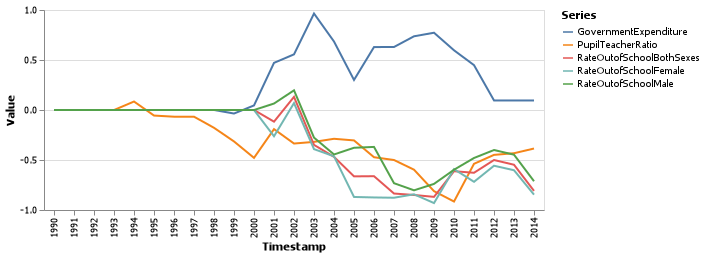

In [17]:
graph = dfTranspose |>
    @filter(_.Country == "United States") |>
    @vlplot(:line, x=:"Timestamp:o", y=:Value, color=:Series)

The story is different for the United Kingdom.  From 2005, pupil-teacher ratio is going up but also the out of school rate is going up.  The budget goes down around 2005.  Perhaps, programs such as after school project were cut off.  Other factors probably caused the out of school rate to increase even with an increasing pupil-teacher ratio.  Apparently, the UK government noticed such undesired trend increasing the 2008 budget for school programs.  Afterwards, out of school rate and pupil-teacher ratio drop similar to the USA case. 

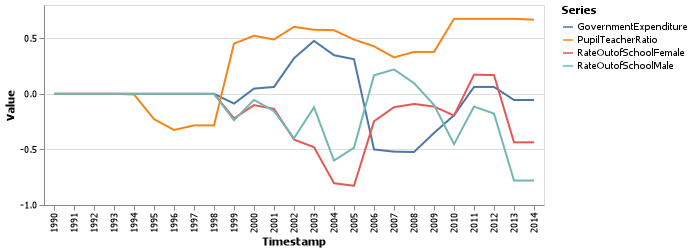

In [18]:
graph = dfTranspose |>
    @filter(_.Country == "United Kingdom") |>
    @filter(_.Series != "RateOutofSchoolBothSexes") |> 
    @vlplot(:line, x=:"Timestamp:o", y=:Value, color=:Series)

Let's see Turkey and Zimbabwe out of school rate and pupil tearch ratio.  Zimbabwe out of school rate for males is higher than famales.  Turkey does not show a gender differnce.  

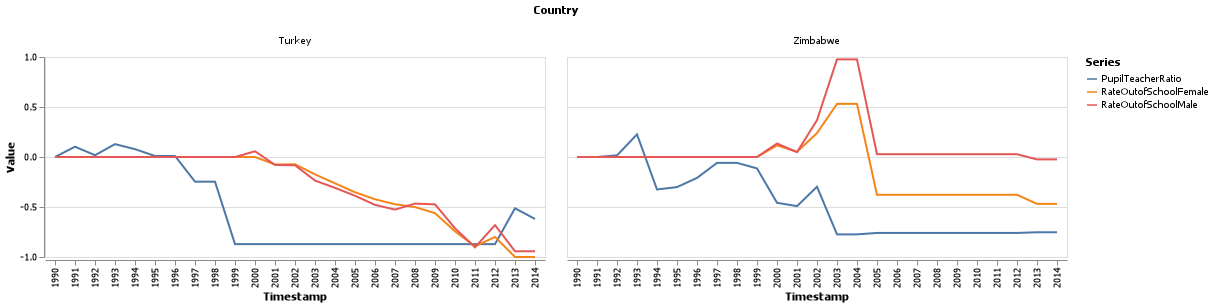

In [19]:
graph = dfTranspose |>
    @filter(_.Country == "Turkey" || _.Country == "Zimbabwe") |>
    @filter(_.Series == "PupilTeacherRatio" || _.Series == "RateOutofSchoolFemale" || _.Series == "RateOutofSchoolMale") |> 
    @vlplot(:line, x=:"Timestamp:o", y=:Value, color=:Series, column=:Country)

Third, the previous graphs are very informative but we can go one step further. We create an interactive data visualizer for our data. We can slice and dice different parts of our data with a few mouse clicks. We can easily gain deeper insight into our data. Incredibly, we can create an interactive application with just one Queryverse command! And, we can easily save UI for sharing.

In [20]:
UI = dfTranspose |> Voyager

Voyager(Electron.Window(Application(Base.PipeEndpoint(Base.Libc.WindowsRawSocket(0x0000000000000530) open, 0 bytes waiting), Process(`'C:\Users\drcxcruz\.julia\artifacts\3cac82ef60c809398a5dd6870b5e97d42dbe2df1\electron.exe' 'C:\Users\drcxcruz\.julia\packages\Electron\MNI24\src\main.js' '\\.\pipe\jlel-642b471050d711ea15cb49255953af32' '\\.\pipe\jlel-sn-642db81050d711ea0521c910d4efc841' 3aT6GK25V1ZmZ9DldpL6Y4vzVkLO/I4md1fBcl1dZ3pzPpG2g2XypVlkPB6y/uwGGmQOoTbsoSiC/sGtshup8uHrz8E2k6f7RkmU9A38H9d9PUfE4/TBROJn5nC6vGk7gwTCuJdgv8M40i8VMVgEizpO+2KeLwEgjl/83SWIOHA=`, ProcessRunning), [1 window]), 1, true, Channel{Any}(sz_max:128,sz_curr:0)))

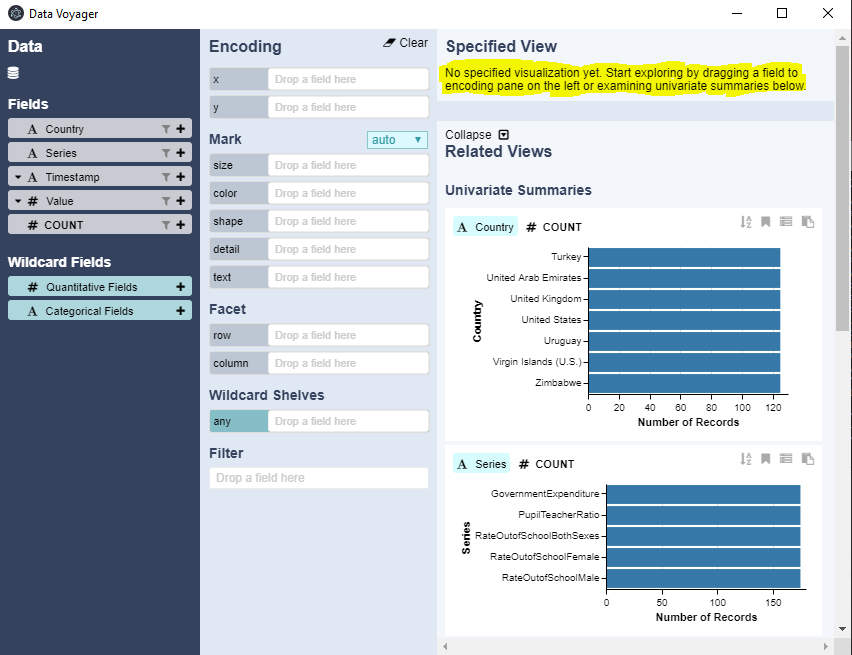

In [1]:
using Images, ImageMagick
img = load("DataVoyagerUI.png")



Here, we save our prepared data in Feather file format for further analysis.  We also stored our graphs and interactive visualizer for future use.



In [22]:
dfSeriesFromZero |> save("SeriesFromZero.feather")
graph |> save("USASeries.vegalite")
UI[] |> save("CountrySeries.vegalite")

## Machine Learning Time
As stated before, we can take our time series and feed them to a machine learning model.  Let use the ARCHModels package to predict future values of As stated before, we can take our time series and feed them to a machine learning model. Let use the ARCHModels package to predict future values of time series. Our time series end in 2014. The goal is to predict from 2015 and 2017. The reason for only three values into the future is that our time series are short. The model could easily predict more values into the future if we had larger time series. 

Remember the topics behind ARCH modeling. Part 1 is the exponential smoothing model. Exponential smoothing considers all observations in the time series. The user is able to define the level of importance of the most recent values. Part 2 is to incorporate trends over time, cyclical variations, and randomness. 

ARIMA is a generalization or expansion of exponential smoothing model. ARIMA has three components.
1. Take the difference between consequence time series values instead of the values themselves. Ths is the d order
2. Autoregression predicts time series values using the previous p time periods
3. Moving average predicts linear errors using the previous q time periods

GARCH estimates the variance, not the values, of a time series. GARCH does not use any difference of variances. The variance shows the range of error in the value estimate.

We predict using the Government Expenditure for USA and UK. The machine learning model and Julia code can easily used any other of the time series in our education statistics. Notice we are predicting using the time series values already normalized and starting from zero. This makes it easy to graph our prediction along the previous graphs. One needs to non-normalize and translate the predictions to see values in the original value range.

In [23]:
dfTimeValuesUK = dfTranspose |>
    @filter(_.Country == "United Kingdom") |>
    @filter(_.Series == "GovernmentExpenditure") |>
    DataFrame

vUKGovernmentExpenditure = replace(dfTimeValuesUK[!, 2], missing=>NaN)  # convert to float vector

dfTimeValuesUSA = dfTranspose |>
    @filter(_.Country == "United States") |>
    @filter(_.Series == "GovernmentExpenditure") |>
    DataFrame

vUSAGovernmentExpenditure = replace(dfTimeValuesUSA[!, 2], missing=>NaN)

25-element Array{Float64,1}:
  0.0                
  0.0                
  0.0                
  0.0                
  0.0                
  0.0                
  0.0                
  0.0                
  0.0                
 -0.03531195537976147
  0.04569456105255278
  0.4715552065502649 
  0.5564670818519    
  0.9646880446202385 
  0.6847297597191496 
  0.3005275687453213 
  0.629466953044126  
  0.6300853855930639 
  0.7370633532545653 
  0.7726682299482557 
  0.5971164127497698 
  0.4485129684606863 
  0.09565219415523354
  0.09565219415523354
  0.09565219415523354

The ARCHModels package finds optimal coeffiencents for the given time series. 

In [24]:
modelUSA = selectmodel(ARCH{0}, vUSAGovernmentExpenditure;  meanspec=ARMA)
println("Model USA", modelUSA)
modelUK = selectmodel(ARCH{0}, vUKGovernmentExpenditure;  meanspec=ARMA)
println("Model UK", modelUK)

Model USA
TGARCH{0,0,0} model with Gaussian errors, T=25.

Mean equation parameters:
────────────────────────────────────────────
     Estimate  Std.Error   z value  Pr(>|z|)
────────────────────────────────────────────
c   0.0766742  0.0456966  1.6779      0.0934
φ₁  0.755663   0.166285   4.5444      <1e-5 
θ₁  0.169521   0.236156   0.717834    0.4729
────────────────────────────────────────────

Volatility parameters:
─────────────────────────────────────────
   Estimate  Std.Error  z value  Pr(>|z|)
─────────────────────────────────────────
ω  0.034447  0.0107551  3.20286    0.0014
─────────────────────────────────────────

Model UK
TGARCH{0,0,0} model with Gaussian errors, T=25.

Mean equation parameters:
──────────────────────────────────────────────
      Estimate  Std.Error    z value  Pr(>|z|)
──────────────────────────────────────────────
c   -0.0908406  0.0128988  -7.04255     <1e-11
φ₁   0.376258   0.272877    1.37886     0.1679
φ₂   0.169518   0.353733    0.479226    0.6318

Now, we are ready to time series predict. We create a function to predict many values in the future. Again, only three values into the future because our time series are very short in time. 

In [25]:
function predictTimeValue(v, window)
    l=length(v)
    predictions = deepcopy(v) 
    for i = 1:futureWindow 
      push!(predictions, 0.0)
    end

    for t = l:l+window-1
      m = selectmodel(ARCH{0}, predictions[1:t];  meanspec=ARMA)  
      predictions[t+1] = predict(m, :return; level=0.05);
    end
    return predictions
end

futureWindow = 3

predictionsUSA = predictTimeValue( vUSAGovernmentExpenditure, futureWindow)
println("USA ", predictionsUSA)

predictionsUK = predictTimeValue( vUKGovernmentExpenditure, futureWindow)
println("UK ", predictionsUK)

USA [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.03531195537976147, 0.04569456105255278, 0.4715552065502649, 0.5564670818519, 0.9646880446202385, 0.6847297597191496, 0.3005275687453213, 0.629466953044126, 0.6300853855930639, 0.7370633532545653, 0.7726682299482557, 0.5971164127497698, 0.4485129684606863, 0.09565219415523354, 0.09565219415523354, 0.09565219415523354, 0.13994636330740723, 0.18238750370821127, 0.21442658590980135]
UK [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.08701043295048905, 0.04774100840553319, 0.0622568753061955, 0.3207623665481527, 0.47715314794959995, 0.34829896021261364, 0.3121314764560086, -0.5002882127419274, -0.5200025781302012, -0.5228468520504, -0.3517072366536428, -0.19263177986860147, 0.06230598254822861, 0.06230598254822861, -0.05491329648730353, -0.05491329648730353, -0.13250846231113753, -0.10259002029188521, -0.08424483319422896]


Now, we add our predictions to original time series.  We will soon see visually the quality of our predictions.

In [26]:
dfPredictions = copy(dfTranspose) 

# you can create a loop to define the 3 rows per country, if you like
l=length(predictionsUSA)
push!(dfPredictions,[Symbol("2015"), predictionsUSA[l-2], "United States", "GovernmentExpenditurePredicted"])
push!(dfPredictions,[Symbol("2016"), predictionsUSA[l-1], "United States", "GovernmentExpenditurePredicted"])
push!(dfPredictions,[Symbol("2017"), predictionsUSA[l],   "United States", "GovernmentExpenditurePredicted"])

l=length(predictionsUK)
push!(dfPredictions,[Symbol("2015"), predictionsUK[l-2], "United Kingdom", "GovernmentExpenditurePredicted"])
push!(dfPredictions,[Symbol("2016"), predictionsUK[l-1], "United Kingdom", "GovernmentExpenditurePredicted"])
push!(dfPredictions,[Symbol("2017"), predictionsUK[l],   "United Kingdom", "GovernmentExpenditurePredicted"])

,Timestamp,Value,Country,Series
,Symbol,Float64⍰,String,String
1,1990,missing,Turkey,GovernmentExpenditure
2,1990,0.0,Turkey,PupilTeacherRatio
3,1990,0.0,Turkey,RateOutofSchoolBothSexes
4,1990,0.0,Turkey,RateOutofSchoolFemale
5,1990,0.0,Turkey,RateOutofSchoolMale
6,1990,0.0,United Arab Emirates,GovernmentExpenditure
7,1990,0.0,United Arab Emirates,PupilTeacherRatio
8,1990,0.0,United Arab Emirates,RateOutofSchoolBothSexes
9,1990,0.0,United Arab Emirates,RateOutofSchoolFemale


The graphs of the original time series and our predictions are next.  I say our predictions are pretty good, what do you think?

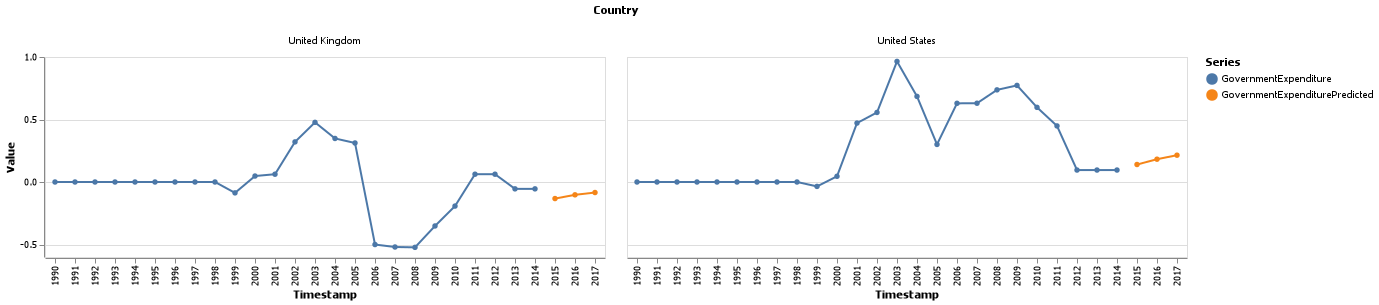

In [27]:
graph = dfPredictions |>
    @filter(_.Country == "United States" || _.Country == "United Kingdom") |>
    @filter(_.Series == "GovernmentExpenditure" || _.Series == "GovernmentExpenditurePredicted") |> 
    @vlplot(
        mark={
        :line,
        point=true
        },
        x=:"Timestamp:o", y=:Value, color=:Series, column=:Country)

## Conclusion
This JupyterLab shows the power and convenience of Queryverse, ARCHModels package, and Julia 1.31. We read real world statistics. Then, we cleaned, imputed, and graph our data. We also created an interactive data visualizer for our data. Lastly, we predicted future values with ARCH modeling. All with simple and fast Julia code.

As most real world data science projects, the data cleaning and preparation is the most time consuming sections. Each data cleaning and preparation step is just a few simple lines of Julia code when using Queryverse. Queryverse allows us to use Dataframes, and IndexTables whenever and however it was convenient. That is amazing. Queryverse works with any Julia package that implements IterableTable package which is a named tuple interface. We could easily use the TimeSeries package if our time period was smaller than 1 year.

VegaLite and Voyager are easy to use and are superior to graphing in R Studio. It literally takes one line of code to graph or create an interactive visualizer of our data. In addition, the ARCHModels package is well documented and easy to use.

## About the Author

Clarman Cruz completed his BS/MS in Computer Science from State University of New York at Stony Brook/Albany. He has more than 15 years technology experience in the banking industry. He is completing on May 2020 his edX MicroMasters in Analytics from Georgia Tech.